In [73]:
import numpy as np
import scipy.linalg as lin
import matplotlib.pyplot as plt
import scipy.stats as sps

# Premier cas : Trajectoires monotones, modèle avec des sauts

$ I_0=10, \alpha_i=-10, \beta_i=-5 $

On considère les poids suivants : $G_p(X_{0:p}^{(k,m)})=exp(\lambda \sum_{i=1}^{I_0}(X_{p,i}^{(n,m)}-X_{p-1,i}^{(n,m)}))$
et donc :
$\Pi_{p=1}^{n-1} G_p(X_{0:p}^{(n,m)})=exp(\lambda \sum_{i=1}^{I_0} X_{n-1,i}^{(n,m)})$

Pour le deuxième cas, le signe de $\lambda$ doit être inversé.

On choisit comme valeur de $\lambda = \frac{\hat{x}_\alpha}{T+1}$

## Preset :

In [74]:
T0,T,Y=120,10,252

alpha=1-1e-4
I0=10
sigma = np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7]) #yearly std
S0=np.array([500,400,300,200,100,50,40,30,20,10])
K=np.array([510,390,310,190,90,55,35,34,17,12])
n=2*int(1e4)

coeffC=np.zeros(I0)-10
coeffP=np.zeros(I0)-5

In [75]:
def d1(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) + sig*np.sqrt(to)/2
def d2(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) - sig*np.sqrt(to)/2


def callPrice(S,t,K,sigma,T):
    return S*sps.norm.cdf(d1((T-t)/Y,S,K,sigma))-K*sps.norm.cdf(d2((T-t)/Y,S,K,sigma))
def putPrice(S,t,K,sigma,T):
    return K*sps.norm.cdf(d1((T-t)/Y,K,S,sigma))-S*sps.norm.cdf(d2((T-t)/Y,K,S,sigma))

In [76]:
def dCall(S,t,K,sigma,T):
  return sps.norm.cdf(d1((T-t)/Y,S,K,sigma))+sps.norm.pdf(d1((T-t)/Y,S,K,sigma))/(sigma*np.sqrt((T-t)/Y))-K*sps.norm.pdf(d2((T-t)/Y,S,K,sigma))/(sigma*np.sqrt((T-t)/Y)*S)
def hedgedCallPrice(S,t,K,sigma,T,S0):
  return callPrice(S,t,K,sigma,T)-dCall(S0,0,K,sigma,T)*S

def dPut(S,t,K,sigma,T):
  return -sps.norm.cdf(d2((T-t)/Y,K,S,sigma))+sps.norm.pdf(d2((T-t)/Y,K,S,sigma))/(sigma*np.sqrt((T-t)/Y))-K*sps.norm.pdf(d1((T-t)/Y,K,S,sigma))/(sigma*np.sqrt((T-t)/Y)*S)
def hedgedPutPrice(S,t,K,sigma,T,S0):
  return putPrice(S,t,K,sigma,T)-dPut(S0,0,K,sigma,T)*S

Définition des Greeks du modèle de Black-Scholes :

In [77]:
#Greeks
#for a call:
def thetaC(S0,K,sigma,T,T0):
    return -S0*sigma*sps.norm.pdf(d1((T0-T)/Y,S0,K,sigma))/(2*np.sqrt((T0-T)/Y))
def deltaC(S0,K,sigma,T,T0):
    return sps.norm.cdf(d1((T0-T)/Y,S0,K,sigma))
def gammaC(S0,K,sigma,T,T0):
    return sps.norm.pdf(d1((T0-T)/Y,K,S0,sigma))/(sigma*S0*np.sqrt((T0-T)/Y))

#for a put:
def thetaP(S0,K,sigma,T,T0):
    return -S0*sigma*sps.norm.pdf(d1((T0-T)/Y,S0,K,sigma))/(2*np.sqrt((T0-T)/Y))
def deltaP(S0,K,sigma,T,T0):
    return sps.norm.cdf(d1((T0-T)/Y,K,S0,sigma))-1
def gammaP(S0,K,sigma,T,T0):
    return sps.norm.pdf(d1((T0-T)/Y,K,S0,sigma))/(sigma*S0*np.sqrt((T0-T)/Y))


On définit deux quantités : $\delta$ et $\Theta$, avec $\delta$ défini pour le cas hedgé et non hedgé:

In [78]:
C=np.diag(sigma*np.sqrt(T/Y)*S0)
delta=coeffC*deltaC(S0,K,sigma,T,T0)+coeffP*deltaP(S0,K,sigma,T,T0)
deltaH=delta-coeffC*dCall(S0,0,K,sigma,T0)-coeffP*dPut(S0,0,K,sigma,T0)
Theta=np.dot(coeffC.T,thetaC(S0,K,sigma,T,T0))+np.dot(coeffP.T,thetaP(S0,K,sigma,T,T0))

Deux méthodes pour calculer des estimations grossières de la VaR utiliser ci-dessous:

In [79]:
def estimVaR(L):
  a=-Theta*T/Y
  b=-np.dot(L.T,np.dot(C.T,delta))
  
  z=sps.norm.ppf(alpha)
  return a+lin.norm(b)*z

def estimVaRHedged(L):
  a=-Theta*T/Y
  b=-np.dot(L.T,np.dot(C,deltaH))
  
  z=sps.norm.ppf(alpha)
  return a+lin.norm(b)*z

Pour exploiter la force d'optimisation de numpy, on définit les matrices suivantes: (éviter les boucles for):

In [80]:
Si=np.zeros((n,I0))
MatSigma=np.zeros((n,I0))
MatK=np.zeros((n,I0)) 
for i in range(I0):
  Si[:,i]+=S0[i]
  MatK[:,i]+=K[i]
  MatSigma[:,i]+=sigma[i]

## Cas Indépendant:

On utilise $logIncr$ comme incrément de la chaîne de Markov, afin d'appliquer l'algorithme Selection-Mutation.

$logIncr \sim \mathcal N(\mu,\Sigma)$
 avec 
 $$\Sigma =
\begin{pmatrix}
\sigma_{1}^{2} & 0 & \cdots & 0 \\
0 & \sigma_{2}^{2} & \cdots & \vdots \\
\vdots  & \vdots  & \ddots & 0  \\
0 &  \cdots & 0 & \sigma_{I_{0}}^{2}
\end{pmatrix}
$$ et $$\mu= \frac{-1}{2}\begin{pmatrix}
\sigma_{1}^{2} \\
\sigma_{2}^{2}  \\
\vdots   \\
\sigma_{I_{0}}^{2}
\end{pmatrix}$$

On estime les valeurs de la VaR dans le cas hedgé et non hedgé. On va utiliser ces deux estimations pour le calibrage du paramètres $\lambda$

In [81]:
roughEstimVaR= estimVaR(np.eye(I0))
roughEstimVaRHedged=estimVaRHedged(np.eye(I0))

print(roughEstimVaR,roughEstimVaRHedged)

211.8434101122977 46.74692993859502


On initialise les incréments qui vont être communs entre la partie hedgée et non hedgée.

In [82]:
Z=np.random.normal(size=(n,T,I0)) 
logIncr=np.zeros((n,T,I0))
for t in range(T): 
  logIncr[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]

### Cas non-hedgé:

#### Estimation de la VaR et la CVaR

In [83]:
X = np.zeros((n, 2,I0))
X[:, 1,:] = logIncr[:, 0,:]


c = 1
la=roughEstimVaR/(T+1)
for p in range(1, T):
    G = np.exp(np.sum(la * ( X[:,1,:]  - X[:,0,:]) ,axis=1))
    c*= np.mean(G)
    
    probas = G/ np.sum(G)
    indices = np.random.choice(np.arange(n), size = n, p = probas)
    X[:,0,:] =X[indices, 1,:]
    X[:,1,:] = X[:,0,:] + logIncr[:, p,:]

Sf=np.zeros((n,I0))

for i in range(I0):
  Sf[:,i]=S0[i]*np.exp(X[:,1,i])

#On rajoute les sauts
r=0.05
paramPoiss=0.02
Nh=np.random.poisson(T*paramPoiss,size=(n,I0))

Sf-=r*Nh*S0

(array([ 192., 1719., 4803., 5879., 4302., 2101.,  774.,  185.,   39.,
           6.]),
 array([-120.32273826,  -29.08755956,   62.14761914,  153.38279784,
         244.61797654,  335.85315524,  427.08833393,  518.32351263,
         609.55869133,  700.79387003,  792.02904873]),
 <a list of 10 Patch objects>)

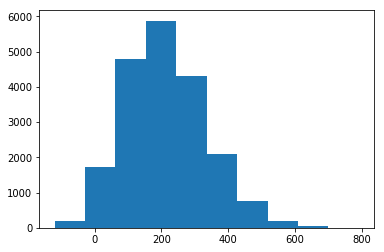

In [84]:
calls=callPrice(Sf,T,MatK,MatSigma,T0)
puts=putPrice(Sf,T,MatK,MatSigma,T0)

callInitial=callPrice(Si,0,MatK,MatSigma,T0)
putInitial=putPrice(Si,0,MatK,MatSigma,T0)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

In [85]:
A=np.zeros((n,2))

r=c*np.exp(-la*np.sum(X[:,0,:],axis=1))

A[:,0],A[:,1]=loss,r

print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]

k,sum=n-1,0
while(sum+A[k,1]/n <1-alpha):
  sum,k=sum+A[k,1]/n,k-1

print(k) #Number of observations below VaR

VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

0.36346361120133985
18017
375.20899743899923 418.2288237007461


#### Convergence des estimateurs :

Cette partie de code a été commenté parce qu'elle prend beaucoup de temps à s'executer. Une deuxième version avec un tri par insertion avec une complexité de $O(nlog(n)) $ .

In [86]:
'''
VaRvalues=[]
ESvalues=[]
A=np.zeros((n,2))
A[:,0],A[:,1]=loss,r
for i in range(10,n,10):
  B=A[:i,:i]
  indexes=np.argsort(B[:,0])

  B=B[indexes,:]
  k,sum=i-1,0
  while(sum+B[k,1]/i <1-alpha):
    sum,k=sum+B[k,1]/i,k-1

  VaRvalues.append(B[k,0])
  ES=np.sum(B[k+1:,0]*B[k+1:,1])/i + (1-alpha-np.sum(B[k+1:,1])/i)*B[k,0]
  ESvalues.append(ES/(1-alpha))
  '''
#Very time consuming method to show convergence

'\nVaRvalues=[]\nESvalues=[]\nA=np.zeros((n,2))\nA[:,0],A[:,1]=loss,r\nfor i in range(10,n,10):\n  B=A[:i,:i]\n  indexes=np.argsort(B[:,0])\n\n  B=B[indexes,:]\n  k,sum=i-1,0\n  while(sum+B[k,1]/i <1-alpha):\n    sum,k=sum+B[k,1]/i,k-1\n\n  VaRvalues.append(B[k,0])\n  ES=np.sum(B[k+1:,0]*B[k+1:,1])/i + (1-alpha-np.sum(B[k+1:,1])/i)*B[k,0]\n  ESvalues.append(ES/(1-alpha))\n  '

In [87]:
#plt.subplot(2,1,1)
#plt.plot(np.arange(10,n,10),VaRvalues,label="Convergence du quantile empirique")

#plt.subplot(2,1,2)
#plt.plot(np.arange(10,n,10),ESvalues,label="Convergence de la CVaR")
#plt.legend(loc='best')

#### Distribution au delà de la $VaR$

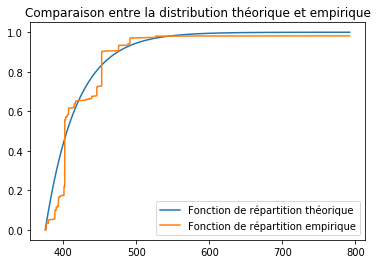

In [88]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

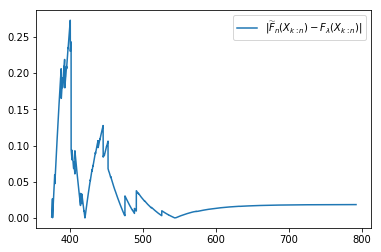

In [89]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

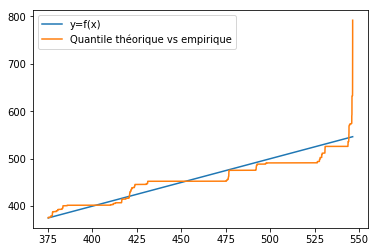

In [90]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

### Cas Hedgé:

#### Estimation de la VaR et la CVaR

In [91]:
X = np.zeros((n, 2,I0))
X[:, 1,:] = logIncr[:, 0,:]


c = 1
la=-roughEstimVaRHedged/(T+1)
for p in range(1, T):
    G = np.exp(np.sum(la * ( X[:,1,:]  - X[:,0,:]) ,axis=1))
    c*= np.mean(G)
    
    probas = G/ np.sum(G)
    indices = np.random.choice(np.arange(n), size = n, p = probas)
    X[:,0,:] =X[indices, 1,:]
    X[:,1,:] = X[:,0,:] + logIncr[:, p,:]

Sf=np.zeros((n,I0))

for i in range(I0):
  Sf[:,i]=S0[i]*np.exp(X[:,1,i])

#On rajoute les sauts
r=0.05
paramPoiss=0.2
Nh=np.random.poisson(T*paramPoiss,size=(n,I0))

Sf-=r*Nh*S0

(array([1.848e+03, 5.561e+03, 5.698e+03, 3.858e+03, 1.907e+03, 7.720e+02,
        2.680e+02, 7.000e+01, 1.700e+01, 1.000e+00]),
 array([ -17.51197366,  206.39983716,  430.31164798,  654.2234588 ,
         878.13526962, 1102.04708044, 1325.95889125, 1549.87070207,
        1773.78251289, 1997.69432371, 2221.60613453]),
 <a list of 10 Patch objects>)

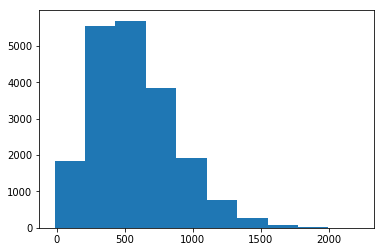

In [92]:
calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

In [93]:
A=np.zeros((n,2))

r=c*np.exp(-la*np.sum(X[:,0,:],axis=1))

A[:,0],A[:,1]=loss,r
print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]

k,sum=n-1,0

while(sum+A[k,1]/n <1-alpha):
  sum+=A[k,1]/n
  k-=1

print(k) #number of observation below VaR
VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

1.0006746426490136
19993
1866.5102245975445 1977.6948821144144


#### Distribution au delà de la $VaR$

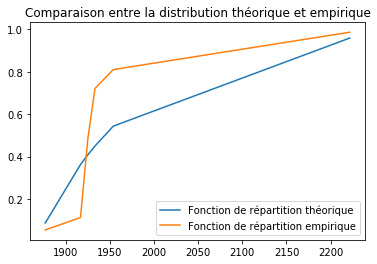

In [94]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

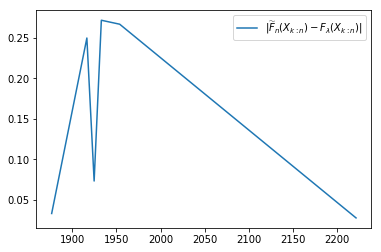

In [95]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')